<a href="https://colab.research.google.com/github/daviddralle/salmonid_and_subsurface/blob/main/recession_salmonid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download files and install packages

In [3]:
import requests
def download_file(url):
  fn = url.split('/')[-1]
  r = requests.get(url, allow_redirects=True)
  open(fn, 'wb').write(r.content)

download_file('https://github.com/daviddralle/salmonid_and_subsurface/raw/main/data_files.zip')
import zipfile
with zipfile.ZipFile('./data_files.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

!pip install -q geopandas
!pip install -q rtree

# Imports and function definitions

In [4]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon
%matplotlib inline
from peakdetect import peakdet as peakdet
from scipy.optimize import curve_fit
import rtree
import geopandas as gp
import glob
import matplotlib
import pickle
import urllib3
import datetime
import time
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

def get_recession_linear(dataframe, returnmean=True):
    selectivity = 50.
    minLen = 4
    start = 0
    option = 1
    alph = 0.9
    ante = 0
    window = 3
    def func(t, q0, k):
        return q0*np.exp(-k*t)
    Ks = []
    d = pd.DataFrame(dataframe.values,columns=['q'])
    selector = (d.q.max()-d.q.min())/selectivity
    [maxtab, mintab]=peakdet(d.q, selector)
    #initialize peaks
    d['peaks']=-1
    #get rid of peaks too close to the start
    if ante>2:
        maxtab = maxtab[maxtab[:,0].astype(int)>ante]
    else:
        maxtab = maxtab[maxtab[:,0].astype(int)>1]
    d.loc[maxtab[:,0].astype(int),'peaks']=maxtab[:,1]
    d['smooth']= d.q.rolling(window=window).mean(); d['smooth'][0:2] = d.q[0:2]
    d['Dunsmooth']= d.q.diff().shift(-1)
    d['DDsmooth']=d['smooth'].diff().shift(-1).diff().shift(-1)
    d['DDunsmooth'] = d.q.diff().shift(-1).diff().shift(-1)
    d = d[:-2]
    #boolean vector for recession periods 
    if option==0:
        d['choose']=d['Dunsmooth']<=0
    else:
        d['choose']=(d['Dunsmooth']<=0) & ((d['DDsmooth']>=0)|(d['DDunsmooth']>=0))
    datesMax = d.loc[d['peaks']>0].index
    for i in np.arange(len(datesMax)-1):
        recStart = datesMax[i]+start; peak1 = datesMax[i]+start; peak2 = datesMax[i+1]
        if peak1>=peak2: 
            continue 
        recEnd = d[peak1:peak2][d[peak1:peak2]['choose']==False].index[0]
        if (len(d[recStart:recEnd])<minLen) | (np.any(d.q[recStart:recEnd]<0)):
            continue
        t = np.arange(len(d.q[recStart:recEnd]))
        q0 = d.q[recStart]
        try:
            popt, cov = curve_fit(func,t,d.q[recStart:recEnd])
        except RuntimeError:
            print('Error encountered in fitting')
            continue
        Ks.append(popt[1])
    if returnmean:
        return np.mean(Ks)
    else:
        return np.median(Ks)

# Get lithology

In [5]:
c = gp.read_file('./catchments.geojson')
c['site'] = c['name']
c = c[['site','geometry']]

basin = gp.read_file('./dry.geojson')
geoms = [item for item in list(basin.geometry[0])]
idx = np.argmax([item.area for item in geoms])
basin.geometry = [geoms[idx]]
basin = basin[['geometry']]
basin['site'] = 'Dry Creek'
gdf = basin.merge(c)
catchments = pd.concat([basin,c])

geology = gp.read_file('./northcoast_geology.geojson')
gageids = {'Dry Creek':'00000000',
           'Elder Creek':'11475560',
           'Outlet Creek':'11472200' , 
           'Van Duzen': '11478500', 
           'Eel, Leggett': '11475800'}
catchments['gage'] = catchments['site'].map(gageids)

catchments = catchments.to_crs('epsg:26910')

melange = []
for i,row in catchments.iterrows():
  clipped = geology.clip(row.geometry)
  clipped['A'] = clipped.geometry.area

  total = clipped.A.sum()
  clipped['frac'] = clipped.A/total
  melange.append(clipped.loc[clipped.PTYPE=='C'].frac.sum())
  print(row.site)
  print(clipped.groupby('PTYPE')['frac'].sum())
  print('\n')
catchments['melange'] = melange
catchments.index = catchments.gage
lith = catchments.copy()

Dry Creek
PTYPE
C     0.996872
CB    0.003128
Name: frac, dtype: float64


Elder Creek
PTYPE
CB    0.090332
Yg    0.909668
Name: frac, dtype: float64


Outlet Creek
PTYPE
C     0.82192
CB    0.07557
QP    0.10251
Name: frac, dtype: float64


Van Duzen
PTYPE
C      0.616268
EB     0.313341
QTw    0.000443
UM     0.021309
Yg     0.048639
Name: frac, dtype: float64


Eel, Leggett
PTYPE
C     0.402407
CB    0.370277
UM    0.030009
Yg    0.197307
Name: frac, dtype: float64




In [6]:
mapper = {'C':'Central Belt',
          'CB':'Coastal Belt',
          'Yg':'Coastal Belt',
          'EB':'Eastern Belt',
          'H2O':'Water'}
geos = list(mapper)
for item in geology.PTYPE.unique():
  if item not in geos:
    mapper[item] = 'Other'

geology['geology'] = geology['PTYPE'].map(mapper)
geology = geology.loc[geology.geology!='Water'].copy()

geology.to_file('./geology_remapped.geojson')

In [7]:
def getFlow(site,start,stop):
    url = 'https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=' + site + '&referred_module=sw&period=&begin_date='+start+'&end_date='+stop
    df = pd.read_csv(url, header=31, delim_whitespace=True)
    df.columns = ['usgs', 'site', 'datetime', 'q', 'a']
    df.index = pd.to_datetime(df.datetime)
    basin = gp.read_file('https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-%s/basin?f=json'%site)
    try: 
      geoms = [item for item in list(basin.geometry[0])]
      idx = np.argmax([item.area for item in geoms])
      basin.geometry = [geoms[idx]]
      print('Found multipolygon - fixing')
    except:
      basin.geometry = basin.geometry
    area_mm2 = basin.to_crs('epsg:26910').geometry[0].area*1000**2
    df = 2.44657555e12*df[['q']]/area_mm2    
    df.q = df.q.astype(float, errors='ignore')
    df.columns = [site]
    return df, basin


# Download and compile flow data

In [8]:
gageNumsToNames = {
                   '11475800':'Eel, Leggett',
                   '11475560':'Elder Creek',
                   '11478500':'Van Duzen',
                   '00000000':'Dry Creek',
                   '11472200':'Outlet Creek',
                    }

gagelist = ['11475560','11472200','11478500','11475800']
startyear = '1950'
endyear = '2019'
startdate = startyear + '-01-01'
enddate = endyear + '-12-31'
basins = []
dfs = []
for gage in gagelist:
  df, basin = getFlow(gage,startdate, enddate)
  dfs.append(df)
  basins.append(basin.geometry[0])

# dataframe of flows
flow = pd.concat(dfs,axis=1)
gdf = gp.GeoDataFrame(geometry=basins,crs='epsg:4326')
gdf['gage'] = gagelist
gdf['name'] = gdf.gage.map(gageNumsToNames)
data = pd.read_csv('./level4e.csv',index_col=0,parse_dates=True)
dry = data[['dryRunoff_mmHour^-1']].resample('D').mean()*24
dry.columns = ['00000000']
gagelist.append('00000000')
flow = pd.concat([flow,dry],axis=1)

# Perform recession analysis

In [9]:
flowdfs = []
Ks = {}
cs = sns.color_palette('Set2',5)
deg = 1
for i,gage in enumerate(gagelist):
  temp = flow[[gage]].copy()
  flowdfs.append(temp)
  Ks[gage] = get_recession_linear(temp[gage], returnmean=False)
 
params_data = pd.DataFrame([{'tau':1/Ks[gage],'gage':gage,
                   'melange':float(lith.loc[gage,'melange'])} for gage in flow.columns],
                   )
params_data = params_data.sort_values('melange')
params_data = params_data.sort_values('melange').reset_index()

# Calculate annual statistics

In [10]:
rainfall = pd.read_csv('./ppt.csv',index_col=0,parse_dates=True)
rows = []
dfs = []
for gage in flow.columns:
  df = flow[[gage]].copy()
  df.columns=['q']
  df['wy'] = [item.year+1 if (item.month<=12)&(item.month>=10) else item.year for item in df.index]
  rain = rainfall[[gage]]
  rain['wy'] = [item.year+1 if (item.month<=12)&(item.month>=10) else item.year for item in rainfall.index]
  sumsum = lambda tempdf: tempdf[(tempdf.index.month>=6)&(tempdf.index.month<=8)].q.sum()
  annualsum = lambda tempdf: tempdf.q.sum()
  getlen = lambda tempdf: np.sum(np.isfinite(tempdf.q))

  # summer runoff fraction
  qSum = df.groupby('wy').apply(sumsum)/df.groupby('wy').apply(annualsum)
  qAnnual = df.groupby('wy').apply(annualsum)
  lens = df.groupby('wy').apply(getlen)
  qSum = qSum[lens>300]
  rain_annual = rain.groupby('wy').mean()
  rr = qAnnual[lens>300].mean()/(rain_annual[lens>300][gage].mean()*365)

  mean_summer_runoff_fraction = qSum.mean()
  stderr = qSum.std()/np.sqrt(len(qSum))
  rows.append([gage,mean_summer_runoff_fraction,stderr,rr])

# create dataframe and merge with lithology breakdown
df = pd.DataFrame(rows)
df.columns = ['gage','qSummerMean','qSummerStdErr','rr']
df = df.set_index('gage')
x = pd.concat([lith, df],axis=1, join='inner')

# Plot exemplary year and recession = f(lithology)

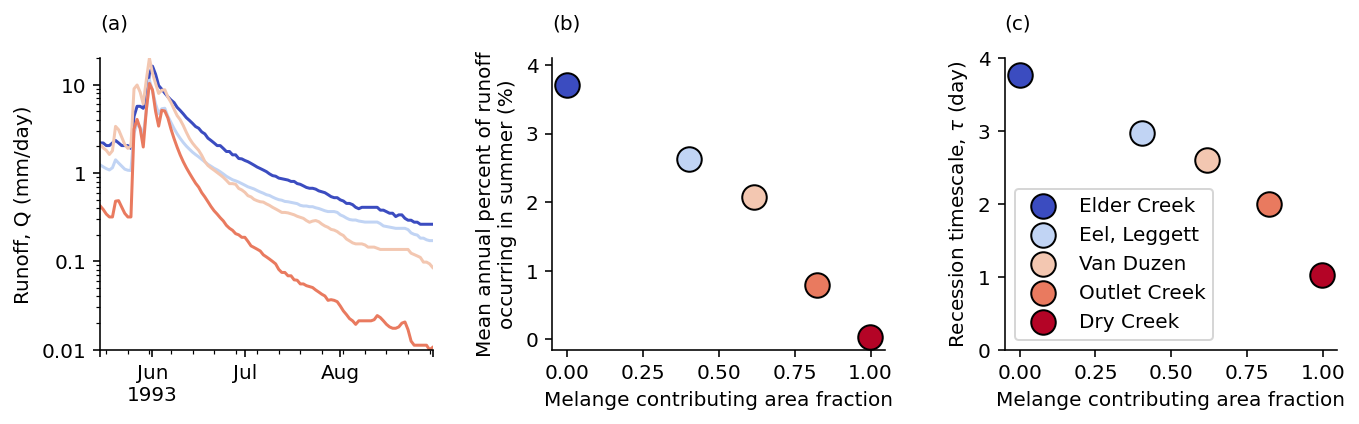

In [11]:
year = 1993
f,axs = plt.subplots(1,3,figsize=(9.6,3.1))
ax = axs[0]
x = x.sort_values('melange')
cmap = matplotlib.cm.get_cmap('coolwarm',)
tempflow = flow.copy()
ax.set_yscale('log')

for i,row in x.iterrows():
  c = np.array(cmap(row.melange))
  if i=='00000000':
    tau =  params_data.loc[params_data.gage==i].tau.values[0]
    axs[2].scatter(row.melange,tau,c=[c],s=150,ec='k',label=gageNumsToNames[row.name])
    axs[1].scatter(row.melange,100*row.qSummerMean,c=[c],s=150,ec='k',label=gageNumsToNames[row.name])
    t = np.linspace(0,10)
    y = np.exp(-t/tau)
    continue
  else:
    tempflow[i].loc['05-15-%s'%str(year):'8-%s'%str(year)].plot(ax=ax,c=c)

  tau =  params_data.loc[params_data.gage==i].tau.values[0]
  axs[2].scatter(row.melange,tau,c=[c],s=150,ec='k',label=gageNumsToNames[row.name])
  axs[1].scatter(row.melange,100*row.qSummerMean,c=[c],s=150,ec='k',label=gageNumsToNames[row.name])

ax.set_yscale('log')
ax.set_ylabel('Runoff, Q (mm/day)')
ax.set_xlabel('')
ax.text(0,1.1,'(a)',transform=ax.transAxes)
ax.set_ylim([1e-2,2e1])
import matplotlib.ticker as ticker
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))


ax = axs[2]
ax.set_ylabel(r'Recession timescale, $\tau$ (day)')
ax.set_xlabel(r'Melange contributing area fraction')
ax.text(0,1.1,'(c)',transform=ax.transAxes)
ax.legend()
ax.set_ylim([0,4])


ax = axs[1]
ax.set_ylim([-.15,4.1])
ax.set_ylabel('Mean annual percent of runoff\noccurring in summer (%)')
ax.set_xlabel(r'Melange contributing area fraction')
ax.text(0,1.1,'(b)',transform=ax.transAxes)


f.tight_layout()
sns.despine(fig=f)
f.savefig('./recession_qfrac.pdf')